# lmax vs time

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

mpl.style.use('ggplot')
print(mpl.style.available)

import cunusht

epsilons = [1e-12, 1e-06, 1e-02] # [1e-12, 1e-10, 1e-08, 1e-06]#, 1e-04, 1e-02]
runs = np.arange(1,6)
lmaxs = np.array([512*n-1 for n in np.arange(1,12)])
good_numbersp1 = np.array([36, 64, 76, 136, 148, 176, 244, 316, 344, 376, 568, 676, 736, 876, 1216, 1324, 1576, 1716, 1876, 2188, 2836, 3088, 3376, 3676, 4376, 5104])-1 # 6076, 6616, 7204, 7876])
lmaxs = np.array(sorted(np.concatenate([lmaxs, good_numbersp1])))
print(lmaxs, type(lmaxs), len(lmaxs))
blacklist_CPU, blacklist_GPU = [], []

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

def lmax2npoints(lmax):
    return (2*lmax)**2

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
[  35   63   75  135  147  175  243  315  343  375  511  567  675  735
  875 1023 1215 1323 1535 1575 1715 1875 2047 2187 2559 2835 3071 3087
 3375 3583 3675 4095 4375 4607 5103 5119 5631] <class 'numpy.ndarray'> 37


## lenmap2gclm

In [168]:
popstr_runinfos_CPU = [
    ["CPU_Lenspyx_transformer"],
    ["init"],
    ["lenmap2gclm"],
    ["adjointsynthesisgeneral"],
    ["setup"],
    ["plane", "SphereInterpol setup", "borders"],
    ["dlm2pointing", "dlm2pointing - allocation", "dlm2pointing - dlm scaling"],
    ["pointing"],
    ["spin-1 synth"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

planned = "planned"
popstrCPU = flatten_extend(popstr_runinfos_CPU)

runinfo = ('CPU', 'lenspyx')
blacklist_runinfos = []
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("CPU_Lenspyx_transformer", "lenmap2gclm") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilons:
    for lmax in lmaxs:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")
    
print("Loading files")
dataCPU = []
for epsilon in epsilons:
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataCPU.append(_)
    print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d1']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilons):
    popstr = popstrCPU
    for popstring in popstr:
        for d in dataCPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
          
ressCPU = []
sortedkeysCPU = [0,3,1,2]
keysCPU = np.array(list(dataCPU[0][0].keys()))[sortedkeysCPU]

print(keysCPU)
for epsiloni, epsilon in enumerate(epsilons):
    data_across_lCPU = {}
    for d in dataCPU[epsiloni]:
        for keyi, key in enumerate(keysCPU):
            if key in data_across_lCPU:
                data_across_lCPU[key].append(d[key])
            else:
                data_across_lCPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lCPU.items()])
    ressCPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressCPU = np.array(ressCPU)
print(ressCPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-10,1e-08,1e-06,1e-04,1e-02 and lmax in 511,1023,1535,2047,2559,3071,3583,4095,4607,5119,5631
All files found
Loading files
1e-12 0.62495
1e-10 0.6622
1e-08 0.6128000000000001
1e-06 0.53138
0.0001 0.29953
0.01 0.26869000000000004
['nuFFT2d1' 'FFT' 'theta resampling' 'leg2alm']
(6, 4, 11, 10) epsilon, keys, lmax


/tmp/ipykernel_564728/3709430980.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.concatenate([[''],lmaxs]))
/tmp/ipykernel_564728/3709430980.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.concatenate([[''],lmaxs]))


(11, 6)


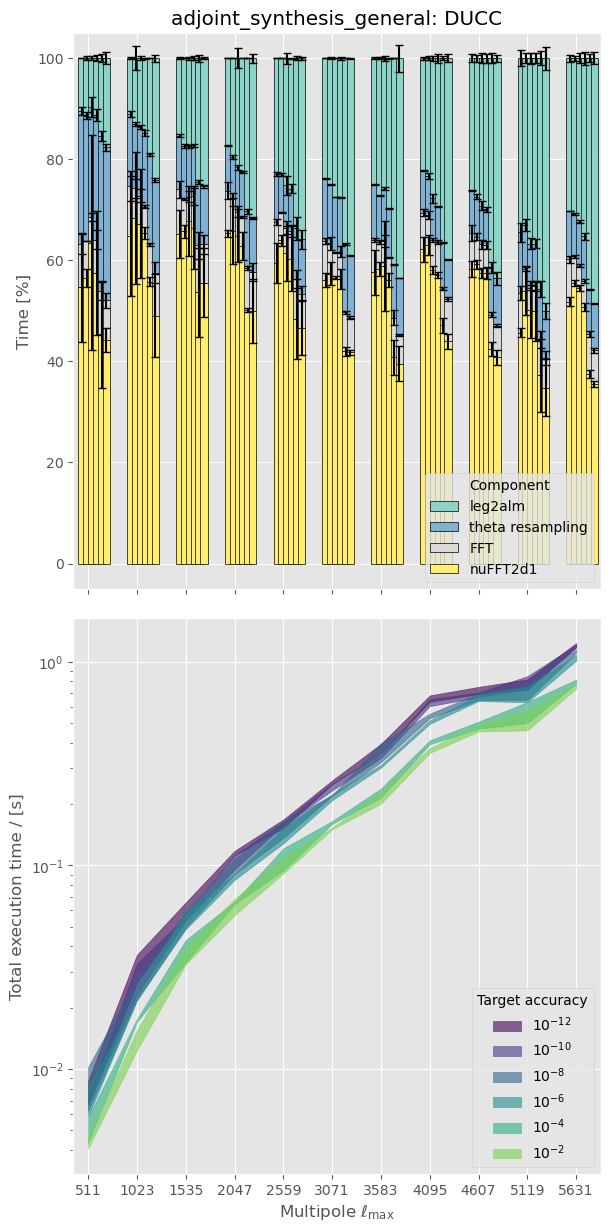

In [169]:
runinfo = ('CPU', 'lenspyx')

colors = plt.cm.Set3(np.linspace(0,1.0,len(keysCPU)))[::-1]
fig, ax = plt.subplots(2,1,figsize=(6,12), sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 1]})
fig.tight_layout()
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressCPU,axis=-1), np.std(ressCPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxs)))
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax[0].bar((np.arange(len(lmaxs)))+0.1*ressacci-0.125, row/total*100, 30*0.005, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysCPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        # ax[0].bar((lmaxs+ressacci*30-len(epsilons)//2*40), row/total*100, 30, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysCPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        bottom += row/total*100

ax[0].set_title("adjoint_synthesis_general: DUCC".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='lower right')

ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].set_xticklabels(np.concatenate([[''],lmaxs]))
# ax[0].set_yticklabels(np.arange(0,110,10))
ax[0].set_xlim(-0.3, 10.5)
# ax[0].set_xlabel(r'Multipole $\ell_{\rm max}$') 


ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')
ax[0].set_ylabel('Time [%]')



resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T

for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressCPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressCPU,axis=-1)[ni], axis=0)
print(lmax_acc_time.shape)
# ax[1].set_xticklabels(accuracies, rotation=40, ha='center')

colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilons)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    ax[1].fill_between(np.arange(len(lmaxs)), acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[acc_datai]))))
ax[1].legend(title='Target accuracy', loc='lower right')

ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].set_xticklabels(np.concatenate([[''],lmaxs]))
ax[1].set_xlim(-0.3, 10.5)
ax[1].set_xlabel(r'Multipole $\ell_{\rm max}$')     
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### GPU

In [170]:
lmaxsGPU = lmaxs # np.array([512*n-1 for n in np.arange(1,11)])
epsilonsGPU = epsilons # [1e-12, 1e-10, 1e-08, 1e-06, 0.0001, 0.01] # [1e-14, 1e-12]# 1e-10, 1e-08, 1e-06]

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["lenmap2gclm"],
    ["adjointsynthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "lenmap2gclm") + "lmax{lmax}_epsilon{epsilon}_run{run:02d}"
dataGPU = []


_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
sortedkeysGPU = [0,2,1,3]
keysGPU = np.array(list(dataGPU[0][0].keys()))[sortedkeysGPU]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(keysGPU):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-10,1e-08,1e-06,1e-04,1e-02 and lmax in 511,1023,1535,2047,2559,3071,3583,4095,4607,5119,5631
All files found
Loading files
11 11
11 11
11 11
11 11
11 11
11 11
(6, 4, 11, 10) epsilon, keys, lmax


/tmp/ipykernel_564728/3929503002.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.concatenate([[''],lmaxs]))
/tmp/ipykernel_564728/3929503002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.concatenate([[''],lmaxs]))


(11, 6)


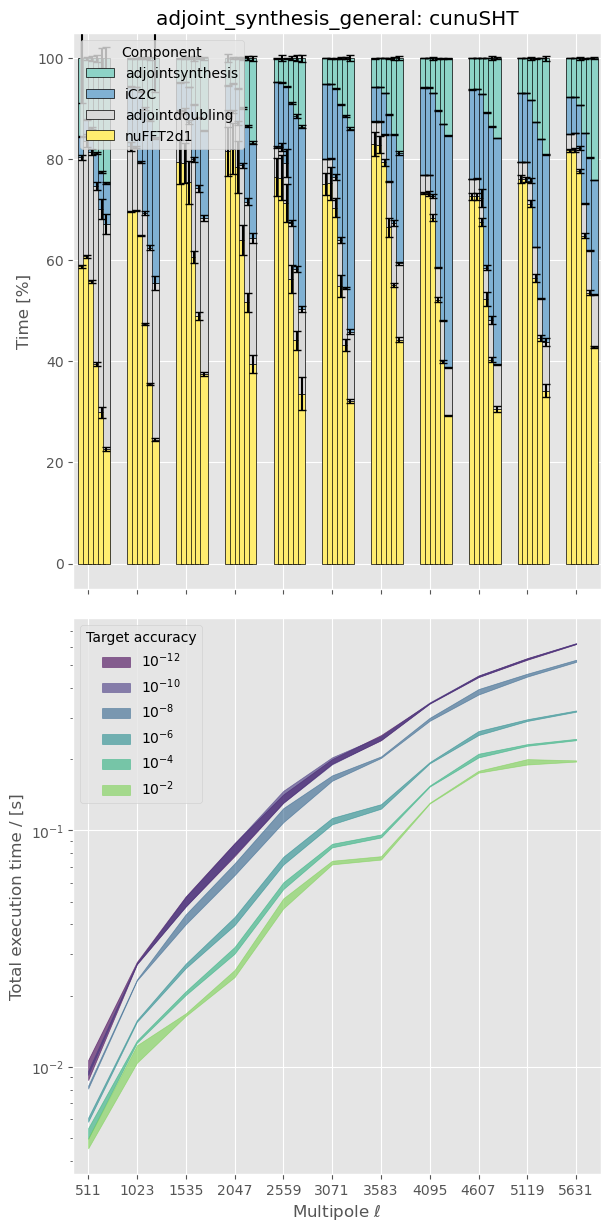

In [171]:
runinfo = ('GPU', 'cufinufft')

colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))[::-1]
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(2,1,figsize=(6,12), sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 1]})
fig.tight_layout()
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=-1), np.std(ressGPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxsGPU)))
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax[0].bar((np.arange(len(lmaxsGPU)))+0.1*ressacci-0.125, row/total*100, 30*0.005, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysGPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        bottom += row/total*100

ax[0].set_title("adjoint_synthesis_general: cunuSHT".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')

ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].set_xticklabels(np.concatenate([[''],lmaxs]))
ax[0].set_xlim(-0.3, 10.5)


ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')
ax[0].set_ylabel('Time [%]')

resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T


for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressGPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressGPU,axis=-1)[ni], axis=0)
print(lmax_acc_time.shape)


colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilonsGPU)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    ax[1].fill_between(np.arange(len(lmaxsGPU)), acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=r"$10^{{{:d}}}$".format(int(np.log10(epsilonsGPU[acc_datai]))))
    # ax[1].plot(lmaxsGPU, acc_data, label=f'{epsilonsGPU[acc_datai]}', color=colors[acc_datai], lw=3)
    # ax[1].plot(epsilons, acc_data, label=f'{lmaxs[::-1][acc_datai]}', color=colors[acc_datai], lw=3)
    
# ax[1].legend(title=r'$\ell_{\rm max}$')

ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].set_xticklabels(np.concatenate([[''],lmaxs]))
ax[1].set_xlim(-0.3, 10.5)

ax[1].legend(title='Target accuracy', loc='upper left')

ax[1].set_xlabel('Accuracy') 
ax[1].set_xlabel('Multipole $\ell_{\rm max}$')    
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### Speed up

Text(0, 0.5, 'Speed up factor')

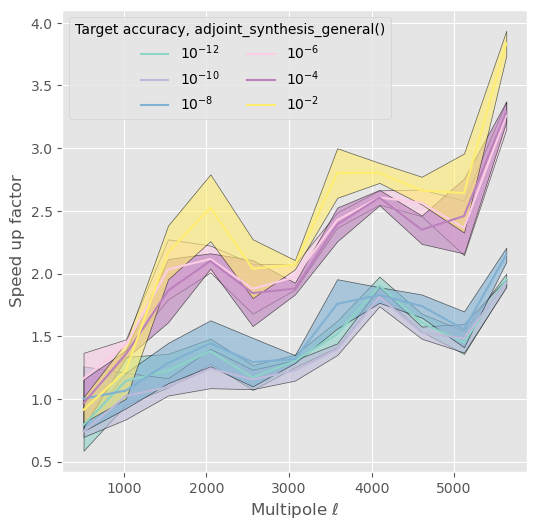

In [167]:
colors = plt.cm.Set3(np.linspace(0,1.0,len(epsilons)))
fig, ax = plt.subplots(1,1,figsize=(6,6))

for ressacci, (ressaccCPU, ressaccGPU, errsCPU, errsGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)), np.std(ressCPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    totalC = np.sum(ressaccCPU, axis=0)
    totalG = np.sum(ressaccGPU, axis=0)
    
    totalerrC = np.sum(errsCPU, axis=0)
    totalerrG = np.sum(errsGPU, axis=0)
    
    # ax.plot(lmaxsGPU, totalC/totalG, label=list(epsilons)[ressacci], color=colors[ressacci], ls='-')
    ax.fill_between(lmaxsGPU, (totalC-totalerrC-totalerrG)/totalG, (totalC+totalerrC+totalerrG)/totalG, color=colors[ressacci], ls='-', alpha=0.6, edgecolor='black')
    ax.plot(lmaxsGPU, totalC/totalG, color=colors[ressacci], ls='-', label=r"$10^{{{:d}}}$".format(int(np.log10(epsilonsGPU[ressacci]))))
ax.legend(title='Target accuracy, adjoint_synthesis_general()', loc='upper left', ncol=2)
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Speed up factor')
# ax[1].set_xscale('log')
# ax.set_yscale('log')

### Lenspyx

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 2815 3071 3327 3583
 3839 4095 4351 4607 4863] 19


/tmp/ipykernel_2275150/3738507269.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])
/tmp/ipykernel_2275150/3738507269.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])


Text(0.25, 0.5, 'GPU')

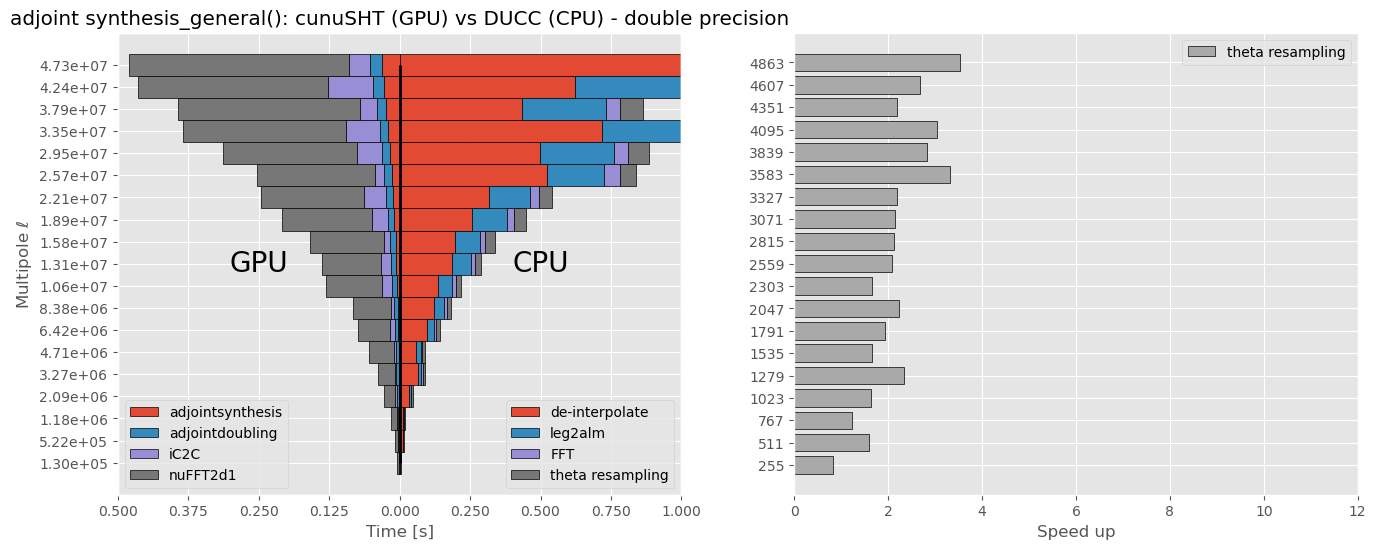

In [47]:
compis = [0,1]
fig, ax = plt.subplots(1,len(runinfos), figsize=(16,6), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

gpu_xlim = 0.5
cpu_xlim = 1
ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])

axt = ax[0].twiny()
keys = list(data[1][0].keys())[::-1]
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1][::-1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi], edgecolor='black')
    bottom -= row
    axt.set_xlim(-gpu_xlim, gpu_xlim)
    
axt.legend(ncol=1, loc='lower left')
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, row in enumerate(ress[0][::-1]): #[:-1,:]
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom, label=list(keys)[::-1][rowi], edgecolor='black')#, color='green')
    bottom += row[mask12]
    ax[0].set_xlim(-cpu_xlim, cpu_xlim)
    
# axt.set_yticks(lmax2npoints(lmax_intersecs))
axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])
        
ax[0].legend(ncol=1, loc='lower right')
axt.vlines(0,0,len(lmax_intersecs[:-1]), color='black', lw=2)
axt.set_title("adjoint synthesis_general(): cunuSHT (GPU) vs DUCC (CPU) - double precision")
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])


width = np.diff(lmax_ress[compis[0]])[0]//3

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = 0 #-width + rowi/len(keys)*2*width
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 200, align='center', label=list(keys)[rowi], edgecolor='black', color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()


ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(["{:d}".format(l) for l in lmax_intersecs])
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[0].set_ylabel(r'Multipole $\ell$')


ax[1].set_xlim(0, 12) # 30

ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU'.format(":\nplanned"), horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

## gclm2lenmap

In [2]:
popstr_runinfos_CPU = [
    ["CPU_Lenspyx_transformer"],
    ["init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["plane", "SphereInterpol setup", "borders"],
    ["dlm2pointing", "dlm2pointing - allocation", "dlm2pointing - dlm scaling"],
    ["pointing"],
    ["spin-1 synth"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["alm2leg", "theta resampling", "FFT"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

planned = "planned"
popstrCPU = flatten_extend(popstr_runinfos_CPU)

runinfo = ('CPU', 'lenspyx')
blacklist_runinfos = []
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("CPU_Lenspyx_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilons:
    for lmax in lmaxs:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")
    
print("Loading files")
dataCPU = []
for epsilon in epsilons:
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataCPU.append(_)
    print(epsilon, len(dataCPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilons):
    popstr = popstrCPU
    for popstring in popstr:
        for d in dataCPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
          
ressCPU = []
sortedkeysCPU = [2,0,1,3]
keysCPU = np.array(list(dataCPU[0][0].keys()))[sortedkeysCPU]
for epsiloni, epsilon in enumerate(epsilons):
    data_across_lCPU = {}
    for d in dataCPU[epsiloni]:
        for keyi, key in enumerate(keysCPU):
            if key in data_across_lCPU:
                data_across_lCPU[key].append(d[key])
            else:
                data_across_lCPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lCPU.items()])
    ressCPU.append(_)
    # print(epsilon, ressCPU[-1])
ressCPU = np.array(ressCPU)
print(ressCPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-06,1e-02 and lmax in 35,63,75,135,147,175,243,315,343,375,511,567,675,735,875,1023,1215,1323,1535,1575,1715,1875,2047,2187,2559,2835,3071,3087,3375,3583,3675,4095,4375,4607,5103,5119,5631
All files found
Loading files
1e-12 37 37
1e-06 37 37
0.01 37 37
(3, 4, 37, 5) epsilon, keys, lmax


/tmp/ipykernel_776668/2606126466.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.concatenate([[''],lmaxs]))
/tmp/ipykernel_776668/2606126466.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.concatenate([[''],lmaxs]))


(37, 3)


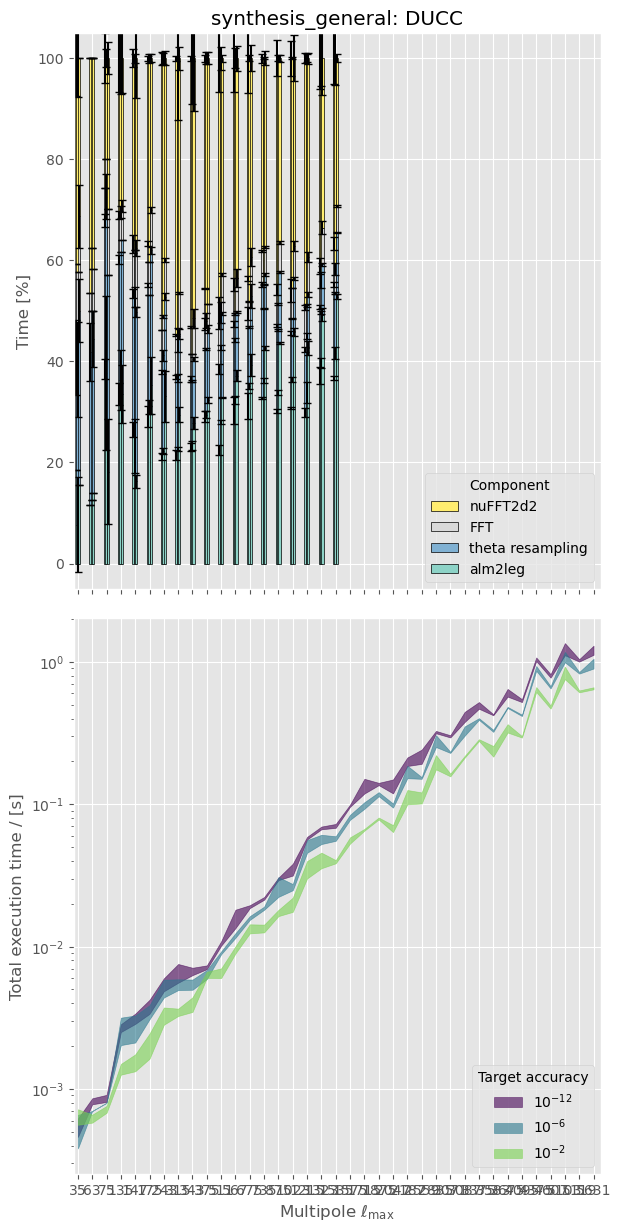

In [68]:
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysCPU)))
fig, ax = plt.subplots(2,1,figsize=(6,12), sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 1]})
fig.tight_layout()
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressCPU,axis=-1), np.std(ressCPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxs[::2])))
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax[0].bar((np.arange(len(lmaxs[::2])))+0.1*ressacci-0.125, (row/total)[::2]*100, 30*0.005, align='center', bottom=bottom, yerr=(err/total)[::2]*100, capsize=3, label=list(keysCPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        # ax[0].bar((lmaxs+ressacci*30-len(epsilons)//2*40), row/total*100, 30, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysCPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        bottom += (row/total)[::2]*100

ax[0].set_title("synthesis_general: DUCC".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='lower right')

ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].set_xticklabels(np.concatenate([[''],lmaxs]))
ax[0].set_xlim(-0.3, 36.5)


ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')
ax[0].set_ylabel('Time [%]')


resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T

for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressCPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressCPU,axis=-1)[ni], axis=0)
print(lmax_acc_time.shape)
# ax[1].set_xticklabels(accuracies, rotation=40, ha='center')

colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilons)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    ax[1].fill_between(np.arange(len(lmaxs)), acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[acc_datai]))))

ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].set_xticklabels(np.concatenate([[''],lmaxs]))

ax[1].legend(title='Target accuracy', loc='lower right')

ax[1].set_xlabel(r'Multipole $\ell_{\rm max}$')     
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### GPU

In [4]:
lmaxsGPU = lmaxs
epsilonsGPU = epsilons # [1e-12, 1e-10, 1e-08, 1e-06, 0.0001, 0.01] # [1e-12, 1e-10, 1e-08, 1e-06]
popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}_run{run:02d}"
dataGPU = []

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
sortedkeysGPU = [0,1,2,3]
keysGPU = np.array(list(dataGPU[0][0].keys()))[sortedkeysGPU]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(keysGPU):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-06,1e-02 and lmax in 35,63,75,135,147,175,243,315,343,375,511,567,675,735,875,1023,1215,1323,1535,1575,1715,1875,2047,2187,2559,2835,3071,3087,3375,3583,3675,4095,4375,4607,5103,5119,5631
All files found
Loading files
37 37
37 37
37 37
(3, 4, 37, 5) epsilon, keys, lmax


(37, 3)


/tmp/ipykernel_776668/1364445453.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.concatenate([[''],lmaxs[::2]]), rotation=40, ha='center')


(0.001, 0.1)

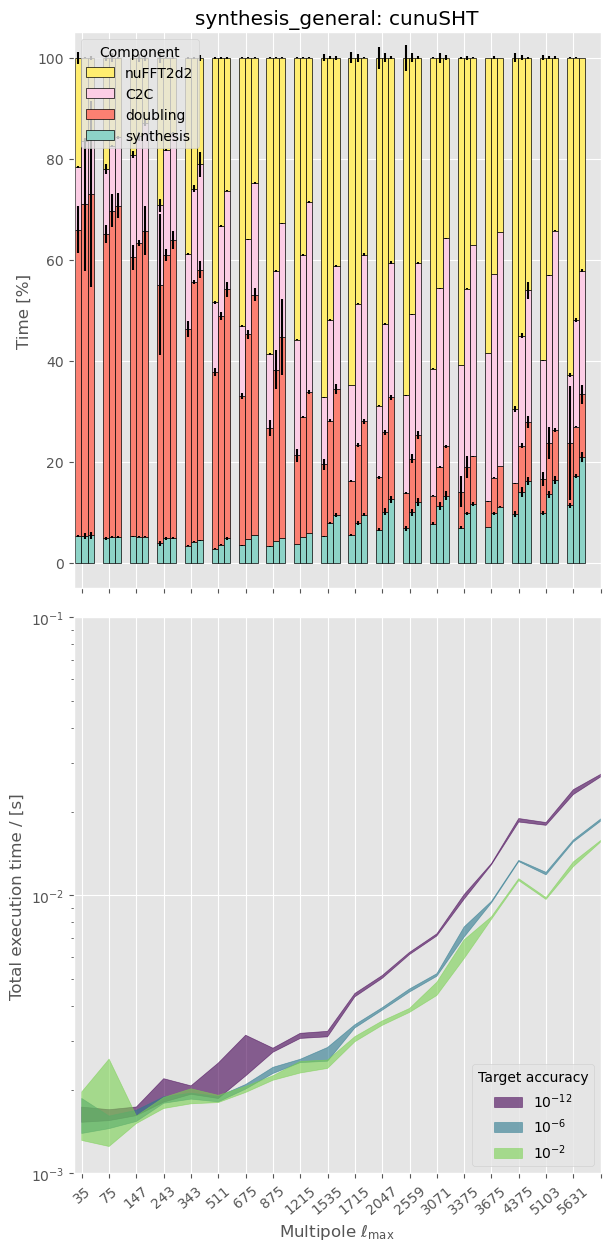

In [67]:
runinfo = ('GPU', 'cufinufft')

colors = plt.cm.Set3(np.linspace(0.0,.95,len(keysGPU)))
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(2,1,figsize=(6,12), sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 1]})
fig.tight_layout()
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=-1), np.std(ressGPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxsGPU[::2])))
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax[0].bar((np.arange(len(lmaxsGPU[::2])))+0.225*ressacci-0.125, (row/total)[::2]*100, 30*0.0075, align='center', bottom=bottom, yerr=(err/total)[::2]*100, capsize=0, edgecolor='black', label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi])
        bottom += (row/total)[::2]*100

ax[0].set_title("synthesis_general: cunuSHT".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')


ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')

# ax[0].set_xlabel('Multipole $\ell$')
ax[0].set_ylabel('Time [%]')

# axes2 = ax[0].twinx()   # mirror them
# axes2.set_ylabel("total execution time / [s]")

resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T


for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressGPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressGPU,axis=-1)[ni], axis=0)
print(lmax_acc_time.shape)


colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilonsGPU)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    pass
    ax[1].fill_between(np.arange(len(lmaxsGPU)), acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=r"$10^{{{:d}}}$".format(int(np.log10(epsilonsGPU[acc_datai]))))
    # ax[1].plot(lmaxsGPU, acc_data, label=f'{epsilonsGPU[acc_datai]}', color=colors[acc_datai], lw=2)

ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].set_xticklabels(np.concatenate([[''],lmaxs[::2]]), rotation=40, ha='center')
ax[1].set_xlim(-0.3, len(lmaxsGPU[::2]))

ax[1].legend(title='Target accuracy', loc='lower right')

ax[1].set_xlabel(r'Multipole $\ell_{\rm max}$')    
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-3,1e-1)

(37, 3)


/tmp/ipykernel_776668/2794976839.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.concatenate([[''],lmaxs[::2]]), rotation=40, ha='center')


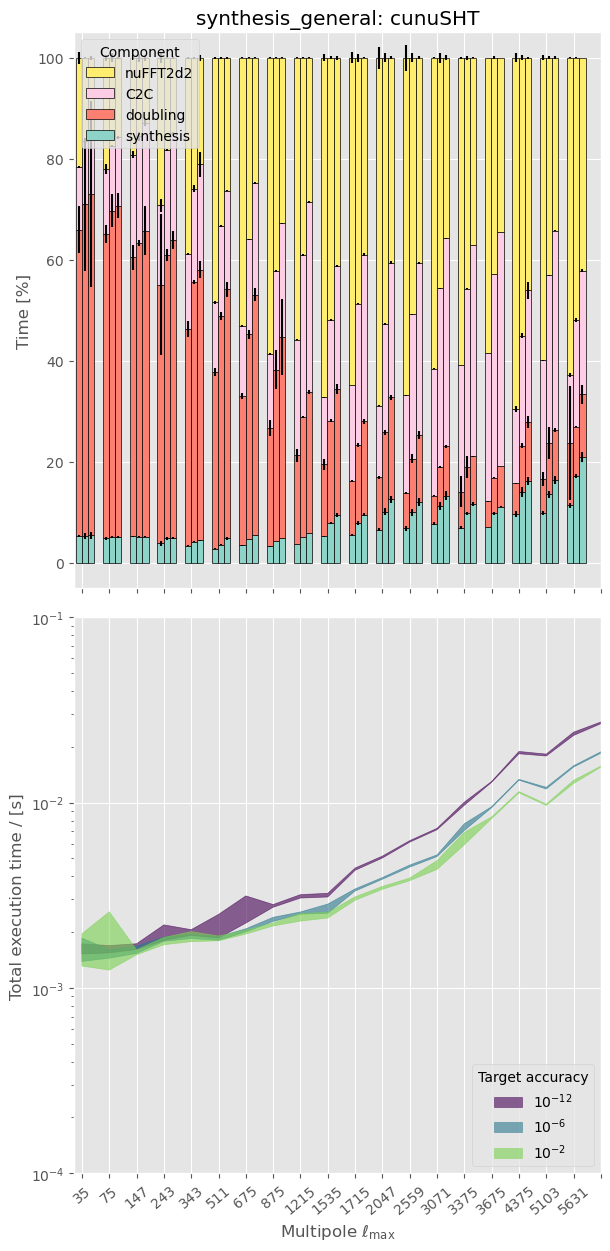

(37, 3)


/tmp/ipykernel_776668/2794976839.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.concatenate([[''],lmaxs[::2]]), rotation=40, ha='center')


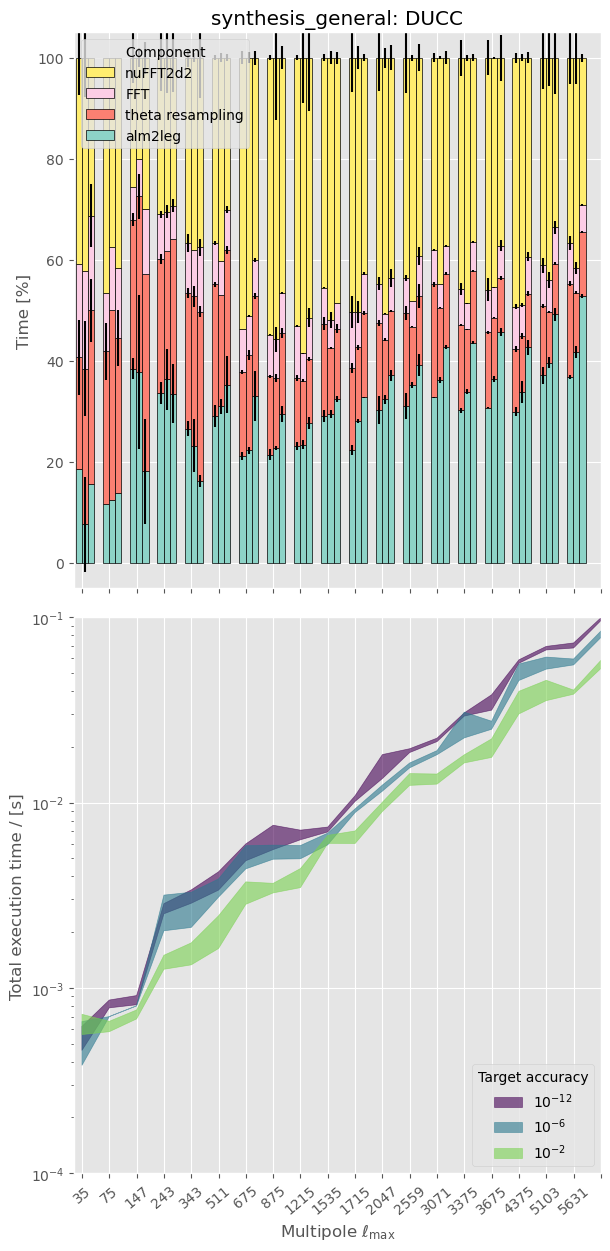

In [77]:
def plot_breakdown(ress, keys, lmaxs, epsilons, runinfo, title_str, fn):
    colors = plt.cm.Set3(np.linspace(0.0,.95,len(keysGPU)))
    fig, ax = plt.subplots(2,1,figsize=(6,12), sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 1]})
    fig.tight_layout()
    for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ress,axis=-1), np.std(ress,axis=-1))):
        total = np.sum(ressacc, axis=0)
        bottom = np.zeros(shape=(len(lmaxs[::2])))
        for rowi, (row, err) in enumerate(zip(ressacc, errs)):
            ax[0].bar((np.arange(len(lmaxs[::2])))+0.225*ressacci-0.125, (row/total)[::2]*100, 30*0.0075, align='center', bottom=bottom, yerr=(err/total)[::2]*100, capsize=0, edgecolor='black', label=keys[rowi] if ressacci==0 else "", color=colors[rowi])
            bottom += (row/total)[::2]*100

    ax[0].set_title(title_str)
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')


    ax[0].set_ylim(-5, 105)
    ax[0].yaxis.set_major_locator(MultipleLocator(20))
    ax[0].yaxis.set_major_formatter('{x:.0f}')

    # ax[0].set_xlabel('Multipole $\ell$')
    ax[0].set_ylabel('Time [%]')

    # axes2 = ax[0].twinx()   # mirror them
    # axes2.set_ylabel("total execution time / [s]")

    resi=0
    accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
    lmax_acc_time = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T
    lmax_acc_time_err = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T


    for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
        lmax_acc_time[:,n] = np.sum(np.mean(ress,axis=-1)[ni], axis=0)
        lmax_acc_time_err[:,n] = np.sum(np.std(ress,axis=-1)[ni], axis=0)
    print(lmax_acc_time.shape)


    colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilonsGPU)))
    for acc_datai, acc_data in enumerate(lmax_acc_time.T):
        pass
        ax[1].fill_between(np.arange(len(lmaxs)), acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=r"$10^{{{:d}}}$".format(int(np.log10(epsilonsGPU[acc_datai]))))
        # ax[1].plot(lmaxsGPU, acc_data, label=f'{epsilonsGPU[acc_datai]}', color=colors[acc_datai], lw=2)

    ax[1].xaxis.set_major_locator(MultipleLocator(1))
    ax[1].set_xticklabels(np.concatenate([[''],lmaxs[::2]]), rotation=40, ha='center')
    ax[1].set_xlim(-0.3, len(lmaxsGPU[::2]))

    ax[1].legend(title='Target accuracy', loc='lower right')

    ax[1].set_xlabel(r'Multipole $\ell_{\rm max}$')    
    ax[1].set_ylabel('Total execution time / [s]')
    # ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_ylim(1e-4,1e-1)
    plt.savefig(os.environ['HOME']+"/output/"+fn+".pdf", bbox_inches='tight')
    
plot_breakdown(ressGPU, keysGPU, lmaxsGPU, epsilonsGPU, runinfo, "synthesis_general: cunuSHT", 'synthgen_GPU')
plt.show()
plot_breakdown(ressCPU, keysCPU, lmaxsGPU, epsilonsGPU, runinfo, "synthesis_general: DUCC", 'synthgen_CPU')

### Transfer / pointing (change popstring)

In [154]:
lmaxsGPU=lmaxs
epsilonsGPU = epsilons # [1e-12, 1e-10, 1e-08, 1e-06]

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    # ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    ["nuFFT2d2", "C2C", "synthesis"],
    ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}_run{run:02d}"
dataGPU = []

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
keysGPU = np.array(list(dataGPU[0][0].keys()))#[[1,0,2,3]]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(d.keys()):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-10,1e-08,1e-06,1e-04,1e-02 and lmax in 511,1023,1535,2047,2559,3071,3583,4095,4607,5119,5631
All files found
Loading files
11 11
11 11
11 11
11 11
11 11
11 11
(6, 1, 11, 10) epsilon, keys, lmax


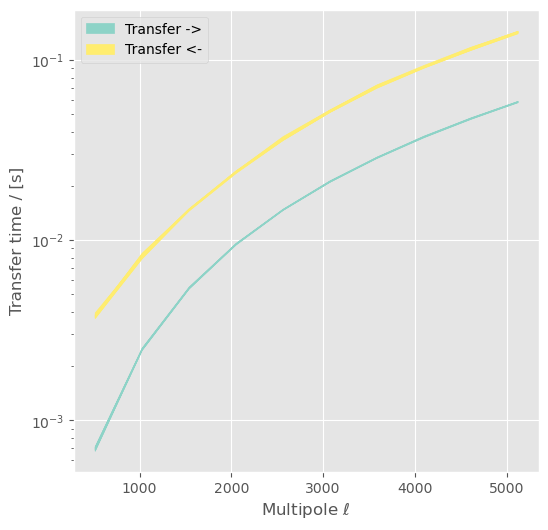

In [22]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(6,6))

for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax.fill_between(lmaxsGPU, row-err, row+err, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Transfer time / [s]')
# ax[1].set_xscale('log')
ax.set_yscale('log')

(0.01, 1.0)

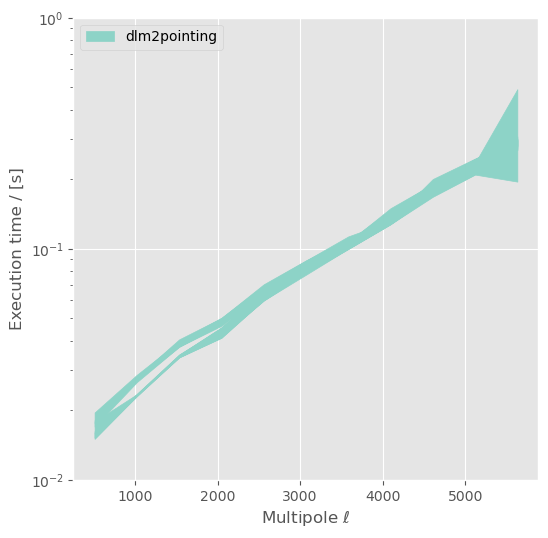

In [155]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(6,6))

for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax.fill_between(lmaxsGPU, row-err, row+err, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Execution time / [s]')
# ax[1].set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e0)

Text(0, 0.5, 'Speed up factor')

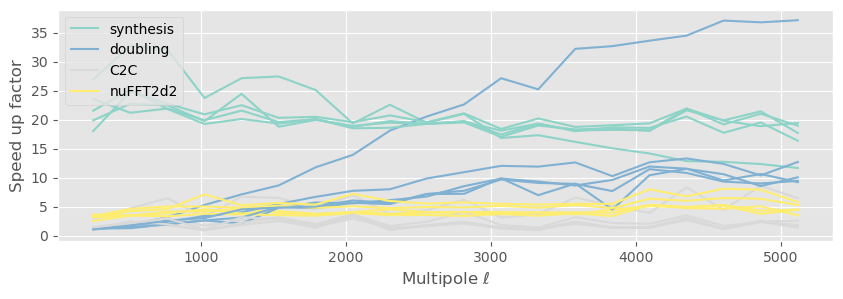

In [20]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(10,3))

for ressacci, (ressaccCPU, ressaccGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)))):
    for rowi, (rowC, rowG) in enumerate(zip(ressaccCPU, ressaccGPU)):
        ax.plot(lmaxsGPU, rowC/rowG, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Speed up factor')
# ax[1].set_xscale('log')
# ax.set_yscale('log')

3 [0.725 0.775 0.825 0.875 0.925 0.975]


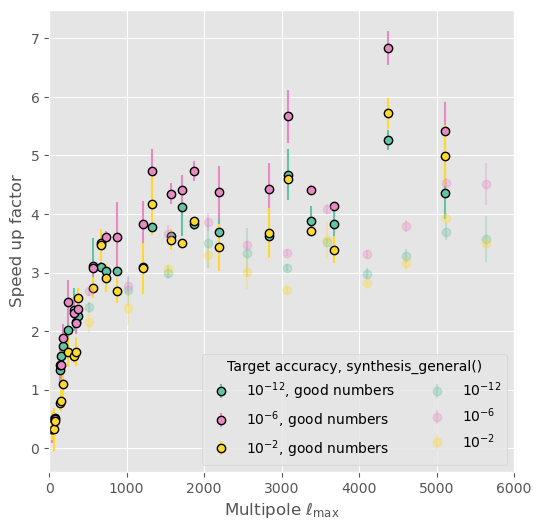

In [123]:
runinfo = ('GPU', 'cufinufft')
# colors = plt.cm.Set3(np.linspace(0.05,.95,len(epsilons)))
colors = plt.cm.Set2(np.linspace(0.1,0.7,len(epsilonsGPU)))
# colors = plt.cm.tab20(np.linspace(0.725,0.975,len(epsilonsGPU*2)))
print(len(colors), np.linspace(0.725,0.975,len(epsilonsGPU*2)))
fig, ax = plt.subplots(1,1,figsize=(6,6))

lmaxs_ = np.array([512*n-1 for n in np.arange(1,12)])
lmaxs2_ = good_numbersp1
sorter = np.argsort(lmaxs)
for li, l in enumerate([lmaxs2_, lmaxs_]):
    for ressacci, (ressaccCPU, ressaccGPU, errsCPU, errsGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)), np.std(ressCPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
        r = np.searchsorted(lmaxs, l, side='right',sorter=sorter)-1
        lmax_choice = lmaxs[r]
        totalC = np.sum(ressaccCPU, axis=0)
        totalG = np.sum(ressaccGPU, axis=0)
        
        totalerrC = np.sum(errsCPU, axis=0)
        totalerrG = np.sum(errsGPU, axis=0)
        
        # ax.plot(lmaxsGPU, totalC/totalG, label=list(epsilons)[ressacci], color=colors[ressacci], ls='-')
        ym = ((totalC-totalerrC-totalerrG)/totalG)[r]
        yp = ((totalC+totalerrC+totalerrG)/totalG)[r]
        yerr = ((totalerrC+totalerrG)/totalG)[r]
        ymean = (totalC/totalG)[r]
        alpha = 1.0 if li == 0 else 0.3
        markeredgecolor = 'black' if li == 0 else None
        # markerfacecolor=colors[ressacci], 
        ax.errorbar(lmax_choice, ymean, yerr, alpha=alpha, marker='o', markeredgecolor=markeredgecolor, color=colors[ressacci], capsize=0, capthick=2, ls='', label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[ressacci])))+"{}".format(", good numbers" if li==0 else ""))
        # ax.plot(lmax_choice, ymean, color=colors[ressacci+li], ls='-', label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[ressacci])))+", {}".format("good numbers" if li==1 else ""))
ax.legend(title='Target accuracy, synthesis_general()', loc='lower right', ncol=2)
ax.set_xlabel(r'Multipole $\ell_{\rm max}$')
ax.set_ylabel('Speed up factor')
ax.set_xlim(0,6000)
plt.savefig(os.environ['HOME']+"/output/synthgen_speedup.pdf", bbox_inches='tight')

In [22]:
lmaxs_ = np.array([512*n-1 for n in np.arange(1,12)])
lmaxs2_ = good_numbersp1
sorter = np.argsort(lmaxs)
r = np.searchsorted(lmaxs, lmaxs_, side='right',sorter=sorter)-1
lmaxs[r]

array([ 511, 1023, 1535, 2047, 2559, 3071, 3583, 4095, 4607, 5119, 5631])

### Old

In [18]:
tot_Gbyte = (5e7+2*5e7+1e8+2*1e4*1e4)*8/1e9
tot_Gbyte

0.000000001702128

1.702128e-09

### Lenspyx

/tmp/ipykernel_993665/750189834.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
/tmp/ipykernel_993665/750189834.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')


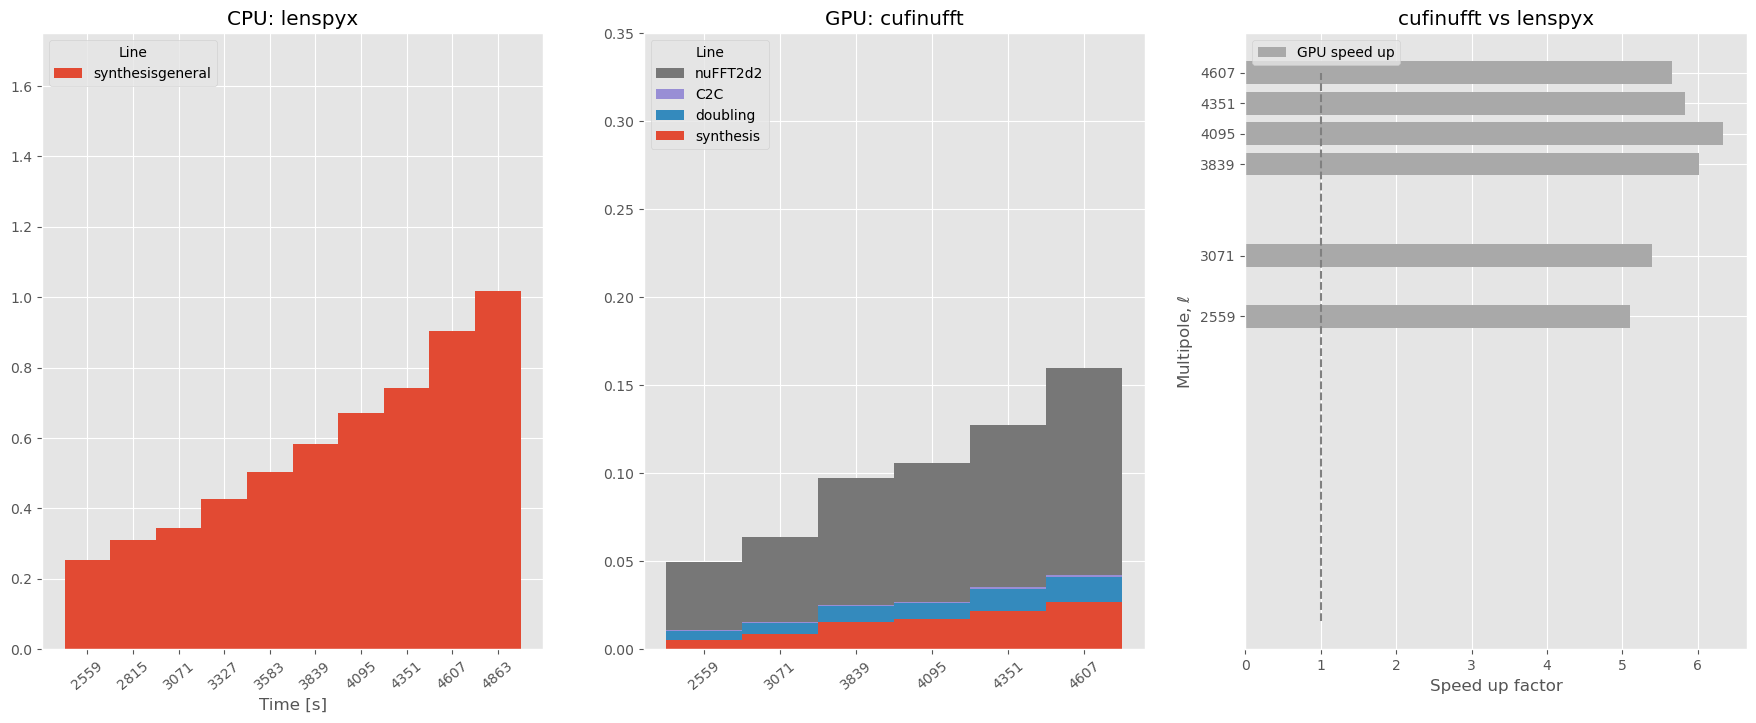

In [25]:
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 1.75)
ax[1].set_ylim(0.0, .35)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')
    
        
axt.legend(ncol=4)
axt.vlines(0,0,len(lmax_intersecs), color='black', lw=2)
axt.set_title("synthesis_general(): {} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')


compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label="GPU speed up", color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], loc='upper left')

# Old

In [148]:
lmax_ress = []
for blacklist_runinfoi, blacklist_runinfo in enumerate(blacklist_runinfos):
    lmax_ress.append(np.array([l for l in lmaxs if l not in blacklist_runinfo]))
print(len(lmax_ress[1]))

0


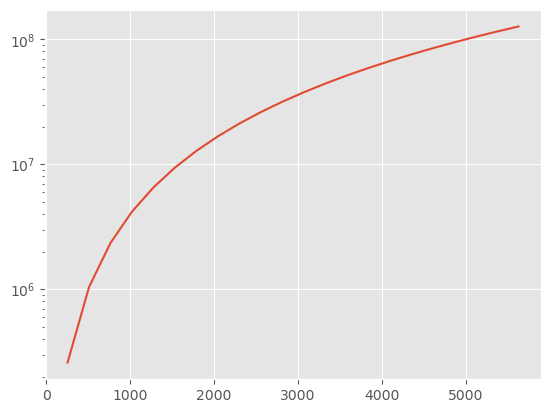

In [ ]:
plt.plot(np.array([256*n-1 for n in range(1,23)]),[lmax2npoints(256*n-1) for n in range(1,23)])
plt.yscale('log')